## Semantic Embeddings

In [11]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [12]:
ds_train, ds_test = tfds.load('ag_news_subset').values()

In [13]:
def extract_text(x):
  return x['title']+' '+x['description']

In [10]:
vocab_size = 5000
vectorizer = keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocab_size, input_shape=(1,))
vectorizer.adapt(ds_train.take(5000).map(extract_text))

In [13]:
vectorizer(['I like to play in dddd on sundays','I am happy'])

<tf.Tensor: shape=(2, 8), dtype=int64, numpy=
array([[ 283,  278,    3,  286,    6,    1,    8, 4370],
       [ 283, 1238, 1885,    0,    0,    0,    0,    0]])>

In [23]:
embedder = keras.layers.Embedding(vocab_size,30)
model = keras.models.Sequential([
    embedder,
    keras.layers.Dense(vocab_size,activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 30)          150000    
                                                                 
 dense_3 (Dense)             (None, None, 5000)        155000    
                                                                 
Total params: 305,000
Trainable params: 305,000
Non-trainable params: 0
_________________________________________________________________


In [25]:
def to_cbow(text,window_size=2):
  res = []
  for i,x in enumerate(text):
    for j in range(max(i-window_size,0),min(i+window_size,len(text))):
      if i!=j:
        res.append([text[j],x])
  return res

to_cbow('I like to visit Moscow'.split())
to_cbow(vectorizer('I like to visit Moscow'))

[[<tf.Tensor: shape=(), dtype=int64, numpy=278>,
  <tf.Tensor: shape=(), dtype=int64, numpy=283>],
 [<tf.Tensor: shape=(), dtype=int64, numpy=283>,
  <tf.Tensor: shape=(), dtype=int64, numpy=278>],
 [<tf.Tensor: shape=(), dtype=int64, numpy=3>,
  <tf.Tensor: shape=(), dtype=int64, numpy=278>],
 [<tf.Tensor: shape=(), dtype=int64, numpy=283>,
  <tf.Tensor: shape=(), dtype=int64, numpy=3>],
 [<tf.Tensor: shape=(), dtype=int64, numpy=278>,
  <tf.Tensor: shape=(), dtype=int64, numpy=3>],
 [<tf.Tensor: shape=(), dtype=int64, numpy=642>,
  <tf.Tensor: shape=(), dtype=int64, numpy=3>],
 [<tf.Tensor: shape=(), dtype=int64, numpy=278>,
  <tf.Tensor: shape=(), dtype=int64, numpy=642>],
 [<tf.Tensor: shape=(), dtype=int64, numpy=3>,
  <tf.Tensor: shape=(), dtype=int64, numpy=642>],
 [<tf.Tensor: shape=(), dtype=int64, numpy=1049>,
  <tf.Tensor: shape=(), dtype=int64, numpy=642>],
 [<tf.Tensor: shape=(), dtype=int64, numpy=3>,
  <tf.Tensor: shape=(), dtype=int64, numpy=1049>],
 [<tf.Tensor: shape=

In [39]:
from tqdm import tqdm

X = []
Y = []
for x in tqdm(ds_train.take(10000).map(extract_text)):
  for w1,w2 in to_cbow(vectorizer(x),window_size=1):
    X.append(w1)
    Y.append(w2)


100%|██████████| 10000/10000 [05:23<00:00, 30.93it/s]


In [40]:
X = np.expand_dims(np.array(X),1)
Y = np.expand_dims(np.array(Y),1)

In [43]:
#model.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='sparse_categorical_crossentropy')
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
model.fit(X,Y,epochs=13,batch_size=128)

Epoch 1/13
2844/2844 [==============================] - 18s 6ms/step - loss: 5.2191 - acc: 0.2056
Epoch 2/13
2844/2844 [==============================] - 14s 5ms/step - loss: 5.1413 - acc: 0.2071
Epoch 3/13
2844/2844 [==============================] - 14s 5ms/step - loss: 5.0846 - acc: 0.2079
Epoch 4/13
2844/2844 [==============================] - 14s 5ms/step - loss: 5.0382 - acc: 0.2087
Epoch 5/13
2844/2844 [==============================] - 14s 5ms/step - loss: 4.9991 - acc: 0.2088
Epoch 6/13
2844/2844 [==============================] - 14s 5ms/step - loss: 4.9653 - acc: 0.2091
Epoch 7/13
2844/2844 [==============================] - 14s 5ms/step - loss: 4.9362 - acc: 0.2094
Epoch 8/13
2844/2844 [==============================] - 14s 5ms/step - loss: 4.9101 - acc: 0.2099
Epoch 9/13
2844/2844 [==============================] - 14s 5ms/step - loss: 4.8872 - acc: 0.2093
Epoch 10/13
2844/2844 [==============================] - 14s 5ms/step - loss: 4.8666 - acc: 0.2097
Epoch 11/13
2844/28

In [46]:
model.save('emb.bin')

In [59]:
vocab = vectorizer.get_vocabulary()
vectors = tf.reshape(embedder(vectorizer(vocab)),(-1,30))
vectors.shape

TensorShape([5000, 30])

In [73]:
v = embedder(vectorizer('moscow'))[0]
np.linalg.norm(vectors-v,axis=1).argsort()

array([1049,   72, 2771, ...,  197, 4669, 1428])

In [86]:
def close_words(x,n=10):
  v = embedder(vectorizer(x))[0]
  t = np.linalg.norm(vectors-v,axis=1).argsort()[:n]
  return [ vocab[i] for i in t ]

close_words('thursday')


['thursday',
 'friday',
 'tuesday',
 'wednesday',
 'monday',
 'yesterday',
 'saturday',
 'sunday',
 'night',
 'immediately']

In [90]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
x2_pca = PCA(n_components=2).fit_transform(vectors)
x2_tsne = TSNE(n_components=2).fit_transform(vectors)

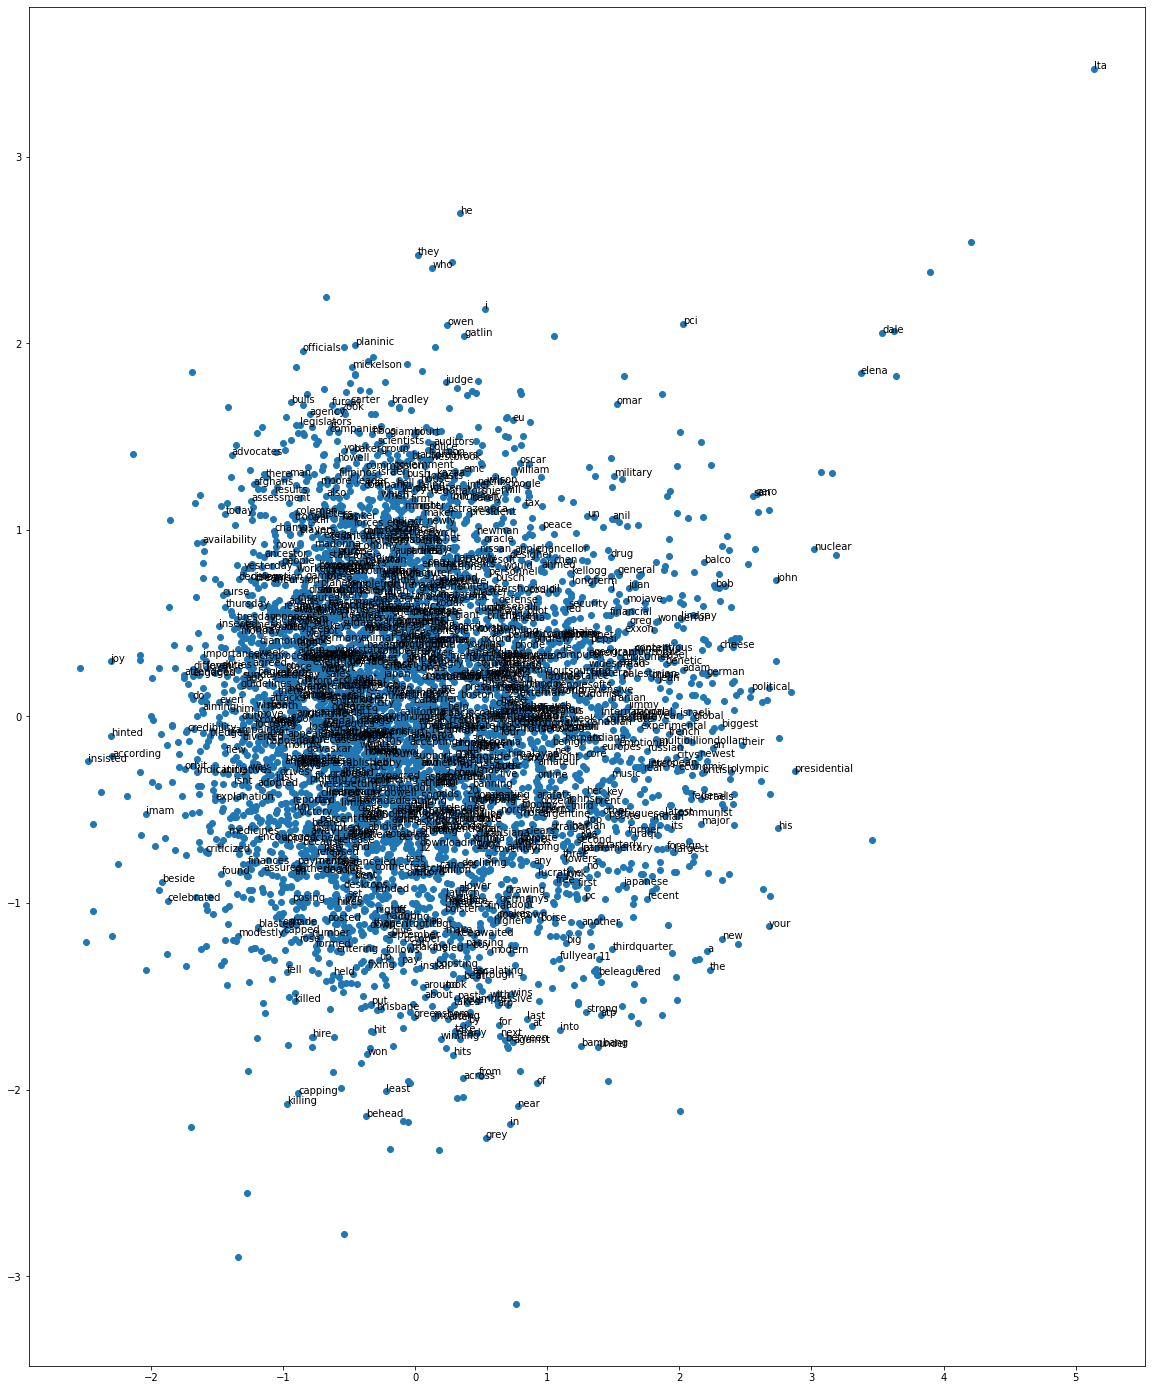

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,25))
plt.scatter(x2_pca[:,0],x2_pca[:,1])
for w, c in zip(vocab[:500],x2_pca):
    plt.annotate(w,c)
for w, c in zip(vocab[::-1][:500],x2_pca[::-1]):
    plt.annotate(w,c)

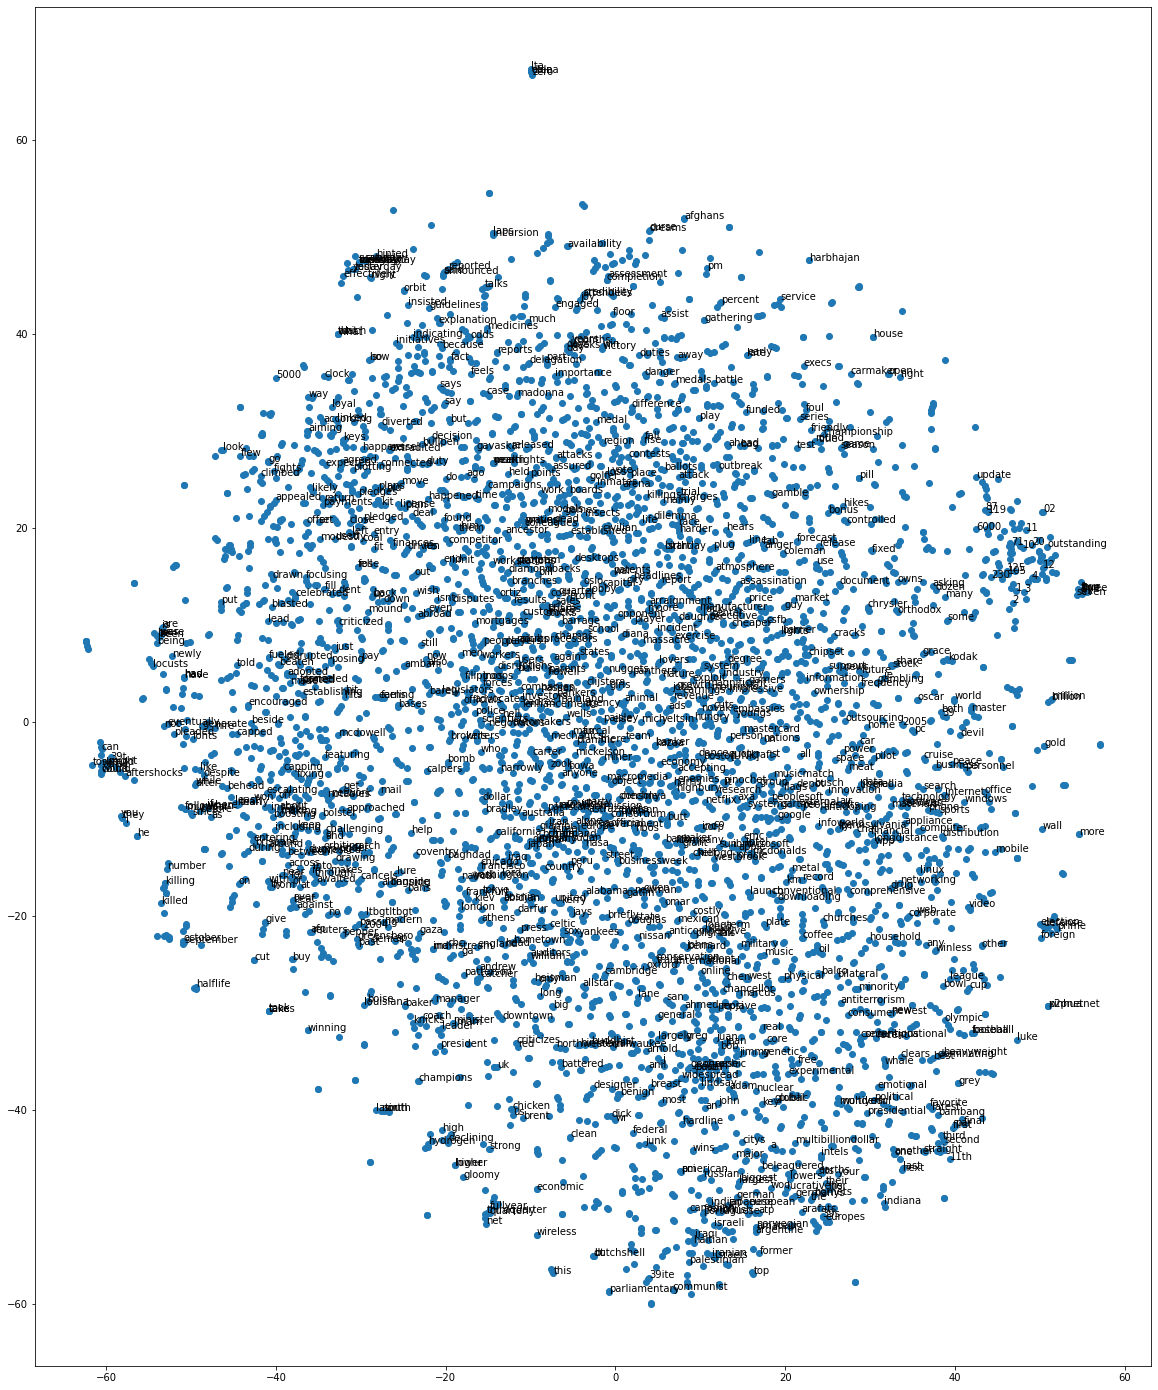

In [92]:
plt.figure(figsize=(20,25))
plt.scatter(x2_tsne[:,0],x2_tsne[:,1])
for w, c in zip(vocab[:500],x2_tsne):
    plt.annotate(w,c)
for w, c in zip(vocab[::-1][:500],x2_tsne[::-1]):
    plt.annotate(w,c)

### Embedding size = 2

In [100]:
embedder = keras.layers.Embedding(vocab_size,2)
model = keras.models.Sequential([
    embedder,
    keras.layers.Dense(vocab_size,activation='softmax')
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 2)           10000     
                                                                 
 dense_5 (Dense)             (None, None, 5000)        15000     
                                                                 
Total params: 25,000
Trainable params: 25,000
Non-trainable params: 0
_________________________________________________________________


In [94]:
from tqdm import tqdm

X = []
Y = []
for x in tqdm(ds_train.take(13000).map(extract_text)):
  for w1,w2 in to_cbow(vectorizer(x),window_size=2):
    X.append(w1)
    Y.append(w2)


100%|██████████| 13000/13000 [12:21<00:00, 17.52it/s]


In [95]:
X = np.expand_dims(np.array(X),1)
Y = np.expand_dims(np.array(Y),1)

In [96]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
hist = model.fit(X,Y,epochs=25,batch_size=128)

Epoch 1/25
10992/10992 [==============================] - 69s 6ms/step - loss: 6.5263 - acc: 0.1466
Epoch 2/25
10992/10992 [==============================] - 66s 6ms/step - loss: 6.2331 - acc: 0.1466
Epoch 3/25
10992/10992 [==============================] - 59s 5ms/step - loss: 6.2107 - acc: 0.1469
Epoch 4/25
10992/10992 [==============================] - 55s 5ms/step - loss: 6.1984 - acc: 0.1470
Epoch 5/25
10992/10992 [==============================] - 57s 5ms/step - loss: 6.1883 - acc: 0.1468
Epoch 6/25
10992/10992 [==============================] - 56s 5ms/step - loss: 6.1790 - acc: 0.1471
Epoch 7/25
10992/10992 [==============================] - 55s 5ms/step - loss: 6.1714 - acc: 0.1474
Epoch 8/25
10992/10992 [==============================] - 56s 5ms/step - loss: 6.1657 - acc: 0.1475
Epoch 9/25
10992/10992 [==============================] - 57s 5ms/step - loss: 6.1613 - acc: 0.1476
Epoch 10/25
10992/10992 [==============================] - 55s 5ms/step - loss: 6.1579 - acc: 0.1476

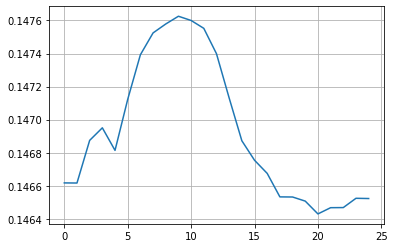

In [97]:
plt.plot(hist.history['acc'])
plt.grid()

In [98]:
vectors2 = tf.reshape(embedder(vectorizer(vocab)),(-1,2))
vectors2.shape

def close_words2(x,n=10):
  v = embedder(vectorizer(x))[0]
  t = np.linalg.norm(vectors2-v,axis=1).argsort()[:n]
  return [ vocab[i] for i in t ]

close_words2('thursday')


['thursday',
 'monday',
 'tuesday',
 'wednesday',
 'less',
 'friday',
 'than',
 'disappointed',
 'exceed',
 'doubled']

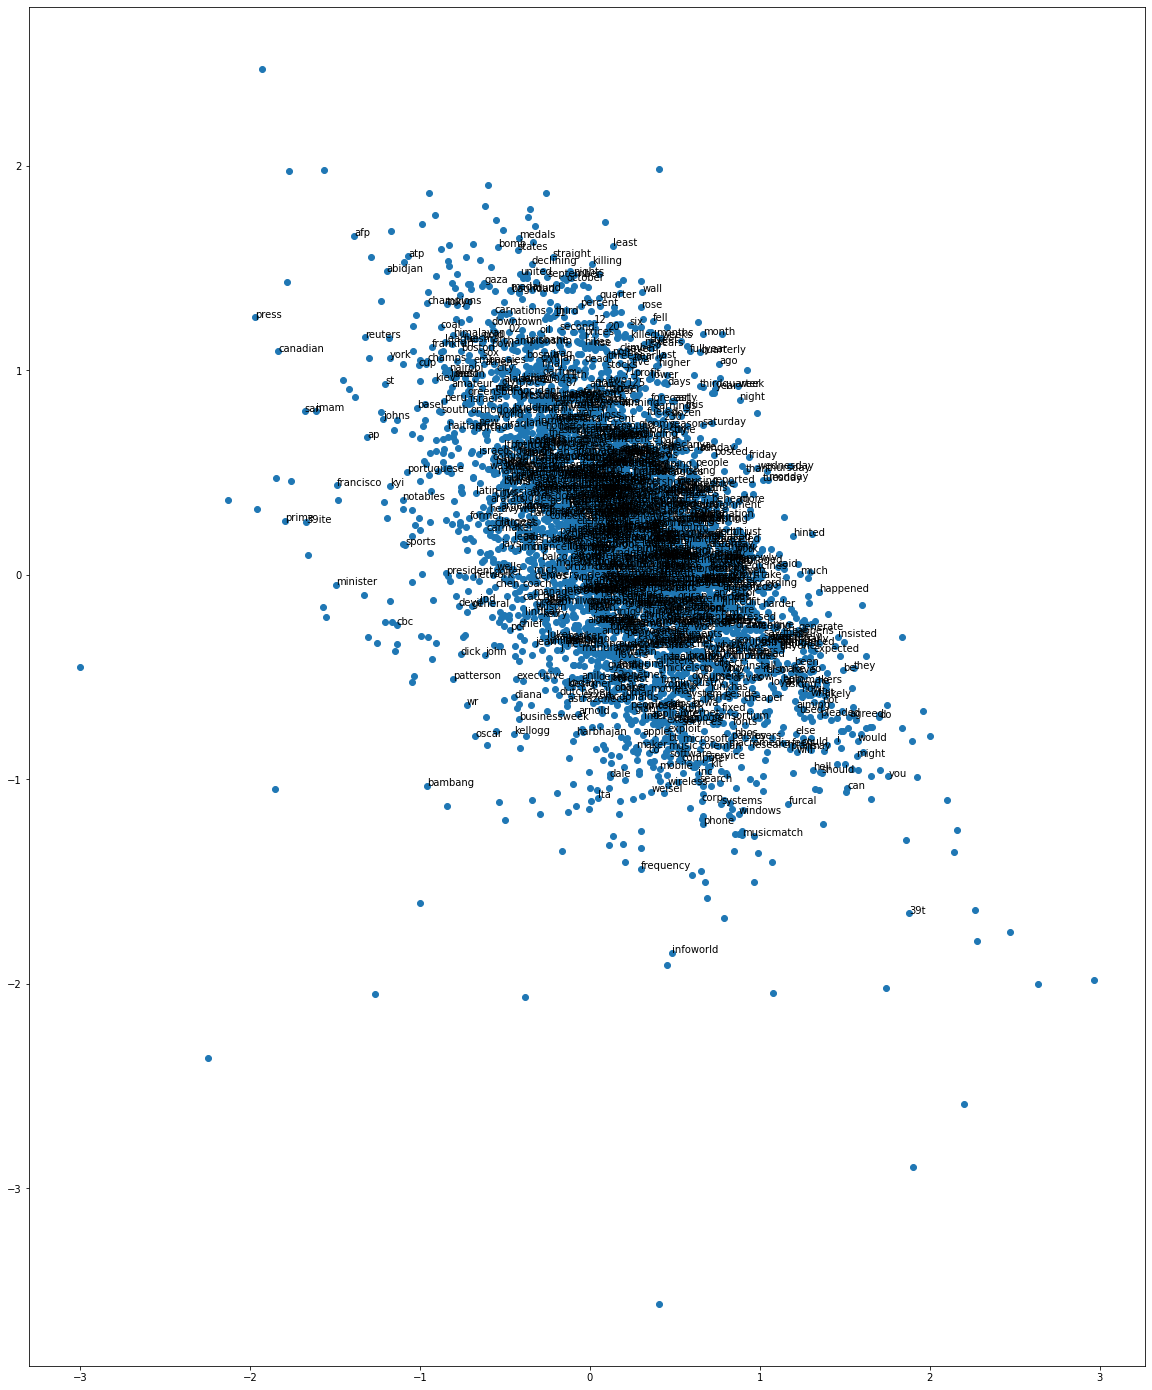

In [99]:
plt.figure(figsize=(20,25))
plt.scatter(vectors2[:,0],vectors2[:,1])
for w, c in zip(vocab[:500],vectors2):
    plt.annotate(w,c)
for w, c in zip(vocab[::-1][:500],vectors2[::-1]):
    plt.annotate(w,c)

In [103]:
embedder = keras.layers.Embedding(vocab_size,30)
model = keras.models.Sequential([
    embedder,
    keras.layers.Dense(vocab_size,activation='softmax')
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 30)          150000    
                                                                 
 dense_6 (Dense)             (None, None, 5000)        155000    
                                                                 
Total params: 305,000
Trainable params: 305,000
Non-trainable params: 0
_________________________________________________________________


In [104]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X,Y,test_size=0.2,shuffle=False)

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
hist = model.fit(train_x,train_y,validation_data=(test_x,test_y),epochs=5,batch_size=128)

Epoch 1/5
8794/8794 [==============================] - 57s 6ms/step - loss: 6.3584 - acc: 0.1463 - val_loss: 6.0504 - val_acc: 0.1589
Epoch 2/5
8794/8794 [==============================] - 49s 6ms/step - loss: 6.0503 - acc: 0.1531 - val_loss: 5.9161 - val_acc: 0.1630
Epoch 3/5
 226/8794 [..............................] - ETA: 55s - loss: 5.9624 - acc: 0.1555

KeyboardInterrupt: ignored

## Gensim and pre-trained Word2Vec

In [1]:
import gensim.downloader as api
w2v = api.load('glove-twitter-50') #word2vec-google-news-300')


[==================================================] 100.0% 199.5/199.5MB downloaded


In [4]:
for w,p in w2v.most_similar('computer'):
    print(f"{w} -> {p}")


cell -> 0.8157469630241394
laptop -> 0.8116585612297058
desktop -> 0.8046691417694092
phone -> 0.8026934266090393
computers -> 0.7978082299232483
camera -> 0.7842990159988403
device -> 0.7839551568031311
ipod -> 0.7806516885757446
app -> 0.7714937329292297
remote -> 0.7652631402015686


In [5]:
w2v.most_similar(positive=['king','woman'],negative=['man'])

[('prince', 0.759779691696167),
 ('stone', 0.7595877051353455),
 ('queen', 0.754626989364624),
 ('meets', 0.7404001355171204),
 ('royal', 0.7376410365104675),
 ('african', 0.7345032691955566),
 ('american', 0.7139526605606079),
 ('virgin', 0.7101487517356873),
 ('mother', 0.7023203372955322),
 ('called', 0.699043869972229)]

In [25]:
v = w2v['king']-w2v['man']+w2v['woman']
n = np.argmin(np.sum((w2v.vectors-v)**2,axis=1))
w2v.index2word[n]

'stone'

In [27]:
vectorizer = keras.layers.experimental.preprocessing.TextVectorization()
vectorizer.adapt(ds_train.take(1500).map(extract_text))

In [29]:
words = []
vecs = []

vocab = vectorizer.get_vocabulary()
for x in ds_train.take(100).map(extract_text):
  for i in vectorizer(x):
    w = vocab[i]
    if w in w2v.index2word and w not in words:
      z = w2v.get_vector(w)
      words.append(w)
      vecs.append(z)

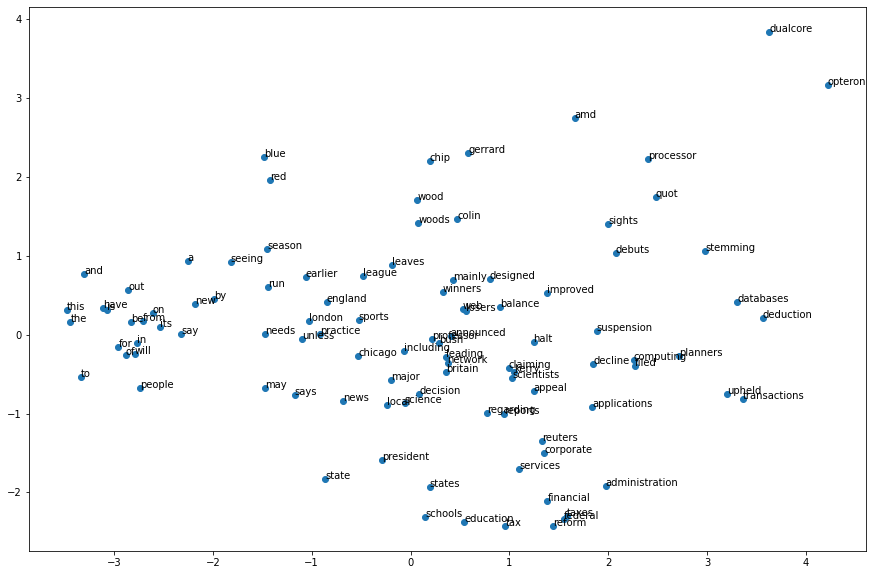

In [31]:
from sklearn.decomposition import PCA

plt.figure(figsize=(15,10))
res = PCA(n_components=2).fit_transform(vecs[:100])
plt.scatter(res[:,0],res[:,1])
for w,c in zip(words,res):
    plt.annotate(w,c)

In [36]:
from tqdm import tqdm
cls = []
vecs = []
for x,y in tqdm(ds_train.take(1000).map(lambda x : (extract_text(x),x['label']))):
  m = []
  for z in vectorizer(x):
    w = vocab[z]
    if w in w2v.index2word:
      m.append(w2v.get_vector(w))
  cls.append(y)
  vecs.append(np.array(m).mean(axis=0))

100%|██████████| 1000/1000 [02:21<00:00,  7.04it/s]


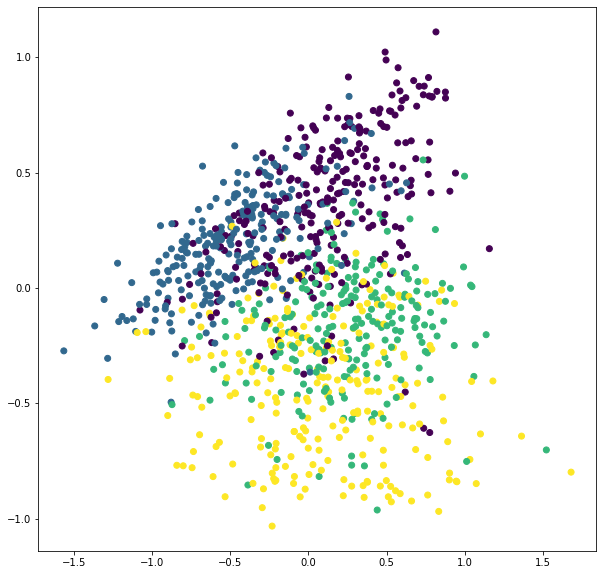

In [38]:
plt.figure(figsize=(10,10))
res = PCA(n_components=2).fit_transform(vecs)
plt.scatter(res[:,0],res[:,1],c=cls)

In [52]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=5).fit(vecs)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


([<matplotlib.axis.XTick at 0x7ff5531f7a90>,
 [Text(0, 0, 'World'),
  Text(1, 0, 'Sports'),
  Text(2, 0, 'Business'),
  Text(3, 0, 'Sci/Tech')])

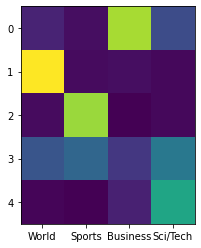

In [53]:
classes = ['World', 'Sports', 'Business', 'Sci/Tech']
m = np.zeros((5,4))

for clu,cla in zip(model.labels_,cls):
  m[clu,cla]+=1

plt.imshow(m)
plt.xticks(range(4),classes)

(array([244.,   0., 214.,   0.,   0., 177.,   0., 228.,   0., 137.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

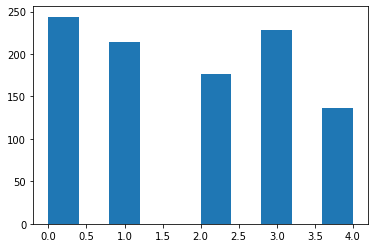

In [55]:
plt.hist(model.labels_)